## Stable Diffusion

In [1]:
! python -m pip install --upgrade pip
! pip install botocore --upgrade --quiet

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.71 requires botocore==1.29.71, but you have botocore 1.29.105 which is incompatible.


In [1]:
!pip list|grep -i diffuser

diffusers                     0.12.0


In [2]:
!echo "Y"|pip uninstall diffusers                     

Found existing installation: diffusers 0.12.0
Uninstalling diffusers-0.12.0:
  Would remove:
    /home/ec2-user/anaconda3/envs/pytorch_p39/bin/diffusers-cli
    /home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/diffusers-0.12.0.dist-info/*
    /home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/diffusers/*
Proceed (Y/n)?   Successfully uninstalled diffusers-0.12.0


In [3]:
!pip install -r /home/ec2-user/SageMaker/sm_sample/dreambooth/inference/requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached diffusers-0.12.0-py3-none-any.whl (604 kB)


In [2]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::687912291502:role/sm-fs-streaming-agg-stack-SageMakerRole-PLMML6TNNEV2
sagemaker bucket: sagemaker-us-west-2-687912291502
sagemaker session region: us-west-2


In [4]:
import torch
print(torch.__version__)  # 查看torch当前版本号
print(torch.version.cuda)  # 编译当前版本的torch使用的cuda版本号
print(torch.cuda.is_available())  # 查看当前cuda是否可用于当前版本的Torch，如果输出

1.13.1+cu117
11.7
True


In [5]:
import os
import json
import boto3
import sagemaker
import uuid
import torch
from torch import autocast
from PIL import Image
import io
import requests
import traceback
import os
import json
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionImg2ImgPipeline
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import deepspeed



#model_dir='/root/dreambooth/models_diffuser/'
model_dir='/home/ec2-user/SageMaker/dst/'
#model_dir='andite/anything-v4.0'
#model_dir='/home/ec2-user/SageMaker/dst/'
pipeline3 = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16, revision="fp16")
pipeline4 = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float16, revision="fp16")
print("model loaded:",pipeline3)
 
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
pipeline3.to("cuda")
pipeline3.enable_attention_slicing()  
pipeline4.to("cuda")
pipeline4.enable_attention_slicing()  

try:
   print("begin load deepspeed....")    
   deepspeed.init_distributed()
   engine = deepspeed.init_inference(
       model=getattr(pipeline4,"model", pipeline4),      # Transformers models
       mp_size=1,        # Number of GPU
       dtype=torch.float16, # dtype of the weights (fp16)
       replace_method="auto", # Lets DS autmatically identify the layer to replace
       replace_with_kernel_inject=True, # replace the model with the kernel injector
   )
#
   if hasattr(pipeline4, "model"):
       pipeline4.model = engine

   print('model accelarate with deepspeed!')
except Exception as e:
   print("deepspeed accelarate excpetion!")
   print(e)
    


The config attributes {'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'time_cond_proj_dim': None, 'time_embedding_type': 'positional', 'timestep_post_act': None} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
The config attributes {'conv_in_kernel': 3, 'conv_out_kernel': 3, 'projection_class_embeddings_input_dim': None, 'time_cond_proj_dim': None, 'time_embedding_type': 'positional', 'timestep_post_act': N

model loaded: StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.12.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

begin load deepspeed....
[2023-04-09 07:09:19,968] [INFO] [comm.py:643:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2023-04-09 07:09:20,242] [INFO] [comm.py:697:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.16.68.150, master_port=29500
[2023-04-09 07:09:20,243] [INFO] [c

Using /home/ec2-user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ec2-user/.cache/torch_extensions/py39_cu117/transformer_inference/build.ninja...
Building extension module transformer_inference...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load transformer_inference op: 0.643160343170166 seconds
[2023-04-09 07:09:21,840] [INFO] [logging.py:77:log_dist] [Rank 0] DeepSpeed-Attention config: {'layer_id': 0, 'hidden_size': 320, 'intermediate_size': 1280, 'heads': 8, 'num_hidden_layers': -1, 'fp16': True, 'pre_layer_norm': True, 'local_rank': -1, 'stochastic_mode': False, 'epsilon': 1e-12, 'mp_size': 1, 'q_int8': False, 'scale_attention': True, 'triangular_masking': False, 'local_attention': False, 'window_size': 256, 'rotary_dim': -1, 'rotate_half': False, 'rotate_every_two': True, 'return_tuple': True, 'mlp_after_attn': True, 'mlp_act_func_type': <ActivationFuncType.GELU: 1>, 'specialized_mode': False, 'training_mp_size': 1, 'bigscience_bloom': False, 'max_out_tokens': 4096, 'scale_attn_by_inverse_layer_idx': False, 'enable_qkv_quantization': False, 'use_mup': False, 'return_single_tuple': False}


Loading extension module transformer_inference...
Using /home/ec2-user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
No modifications detected for re-loaded extension module transformer_inference, skipping build step...
Loading extension module transformer_inference...


Time to load transformer_inference op: 0.09824466705322266 seconds


Using /home/ec2-user/.cache/torch_extensions/py39_cu117 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ec2-user/.cache/torch_extensions/py39_cu117/spatial_inference/build.ninja...
Building extension module spatial_inference...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load spatial_inference op: 0.6428096294403076 seconds
**** found and replaced unet w. <class 'deepspeed.model_implementations.diffusers.unet.DSUNet'>
model accelarate with deepspeed!


Loading extension module spatial_inference...


### Inference

In [6]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64
import matplotlib.pyplot as plt

# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return Image.open(buffer)

# display PIL images as grid
def display_images(images=None,columns=3, width=100, height=100):
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)
        
def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key        

In [50]:
import time
from diffusers import EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, HeunDiscreteScheduler, LMSDiscreteScheduler, KDPM2DiscreteScheduler, KDPM2AncestralDiscreteScheduler,DDIMScheduler
samplers = {
    "euler_a": EulerAncestralDiscreteScheduler,
    "eular": EulerDiscreteScheduler,
    "heun": HeunDiscreteScheduler,
    "lms": LMSDiscreteScheduler,
    "dpm2": KDPM2DiscreteScheduler,
    "dpm2_a": KDPM2AncestralDiscreteScheduler,
    "ddim": DDIMScheduler
}
s3_client = boto3.client('s3')
#prompt = "A dog trying catch a flying pizza art drawn by disney concept artists, golden colour, high quality, highly detailed, elegant, sharp focus"
prompt = "callie, inkling, splatoon, cute, forest background"
negative_prompt='(worst quality, low quality:1.4), simple background'
seed=270522672
#seed=74637347435
simpler="ddim"

#prompt = "priest, blue robes, 68 year old nun, national geographic, portrait, photo, photography"
#prompt = "hotel room with a swimming pool outside of the window, TV on the table, moon in the sky"

start=time.time()
generator = torch.Generator(device='cuda').manual_seed(seed)
pipeline4.scheduler = samplers[simpler].from_config(pipeline4.scheduler.config)
images = pipeline4(prompt, negative_prompt=negative_prompt,num_images_per_prompt=2, num_inference_steps=30, guidance_scale=7.5,generator=generator).images
print(f"Time taken: {time.time() - start}s")
ret_images=[]
for image in images:
   bucket, key = get_bucket_and_key("s3://sagemaker-us-west-2-687912291502/deepspeed/")
   key = '{0}{1}.png'.format(key, uuid.uuid4())
   buf = io.BytesIO()
   image.save(buf, format='PNG')
   s3_client.put_object(
       Body = buf.getvalue(), 
       Bucket = bucket, 
       Key = key, 
       ContentType = 'image/PNG'
   )
   ret_images.append(image)
   print('image: ', 's3://{0}/{1}'.format(bucket, key))



  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Time taken: 3.043560028076172s
image:  s3://sagemaker-us-west-2-687912291502/deepspeed/5a4087ba-ae5a-489b-9ce1-b51cd1a80b19.png
image:  s3://sagemaker-us-west-2-687912291502/deepspeed/8c01a73c-43ed-4bf4-a23a-761fab5818c6.png


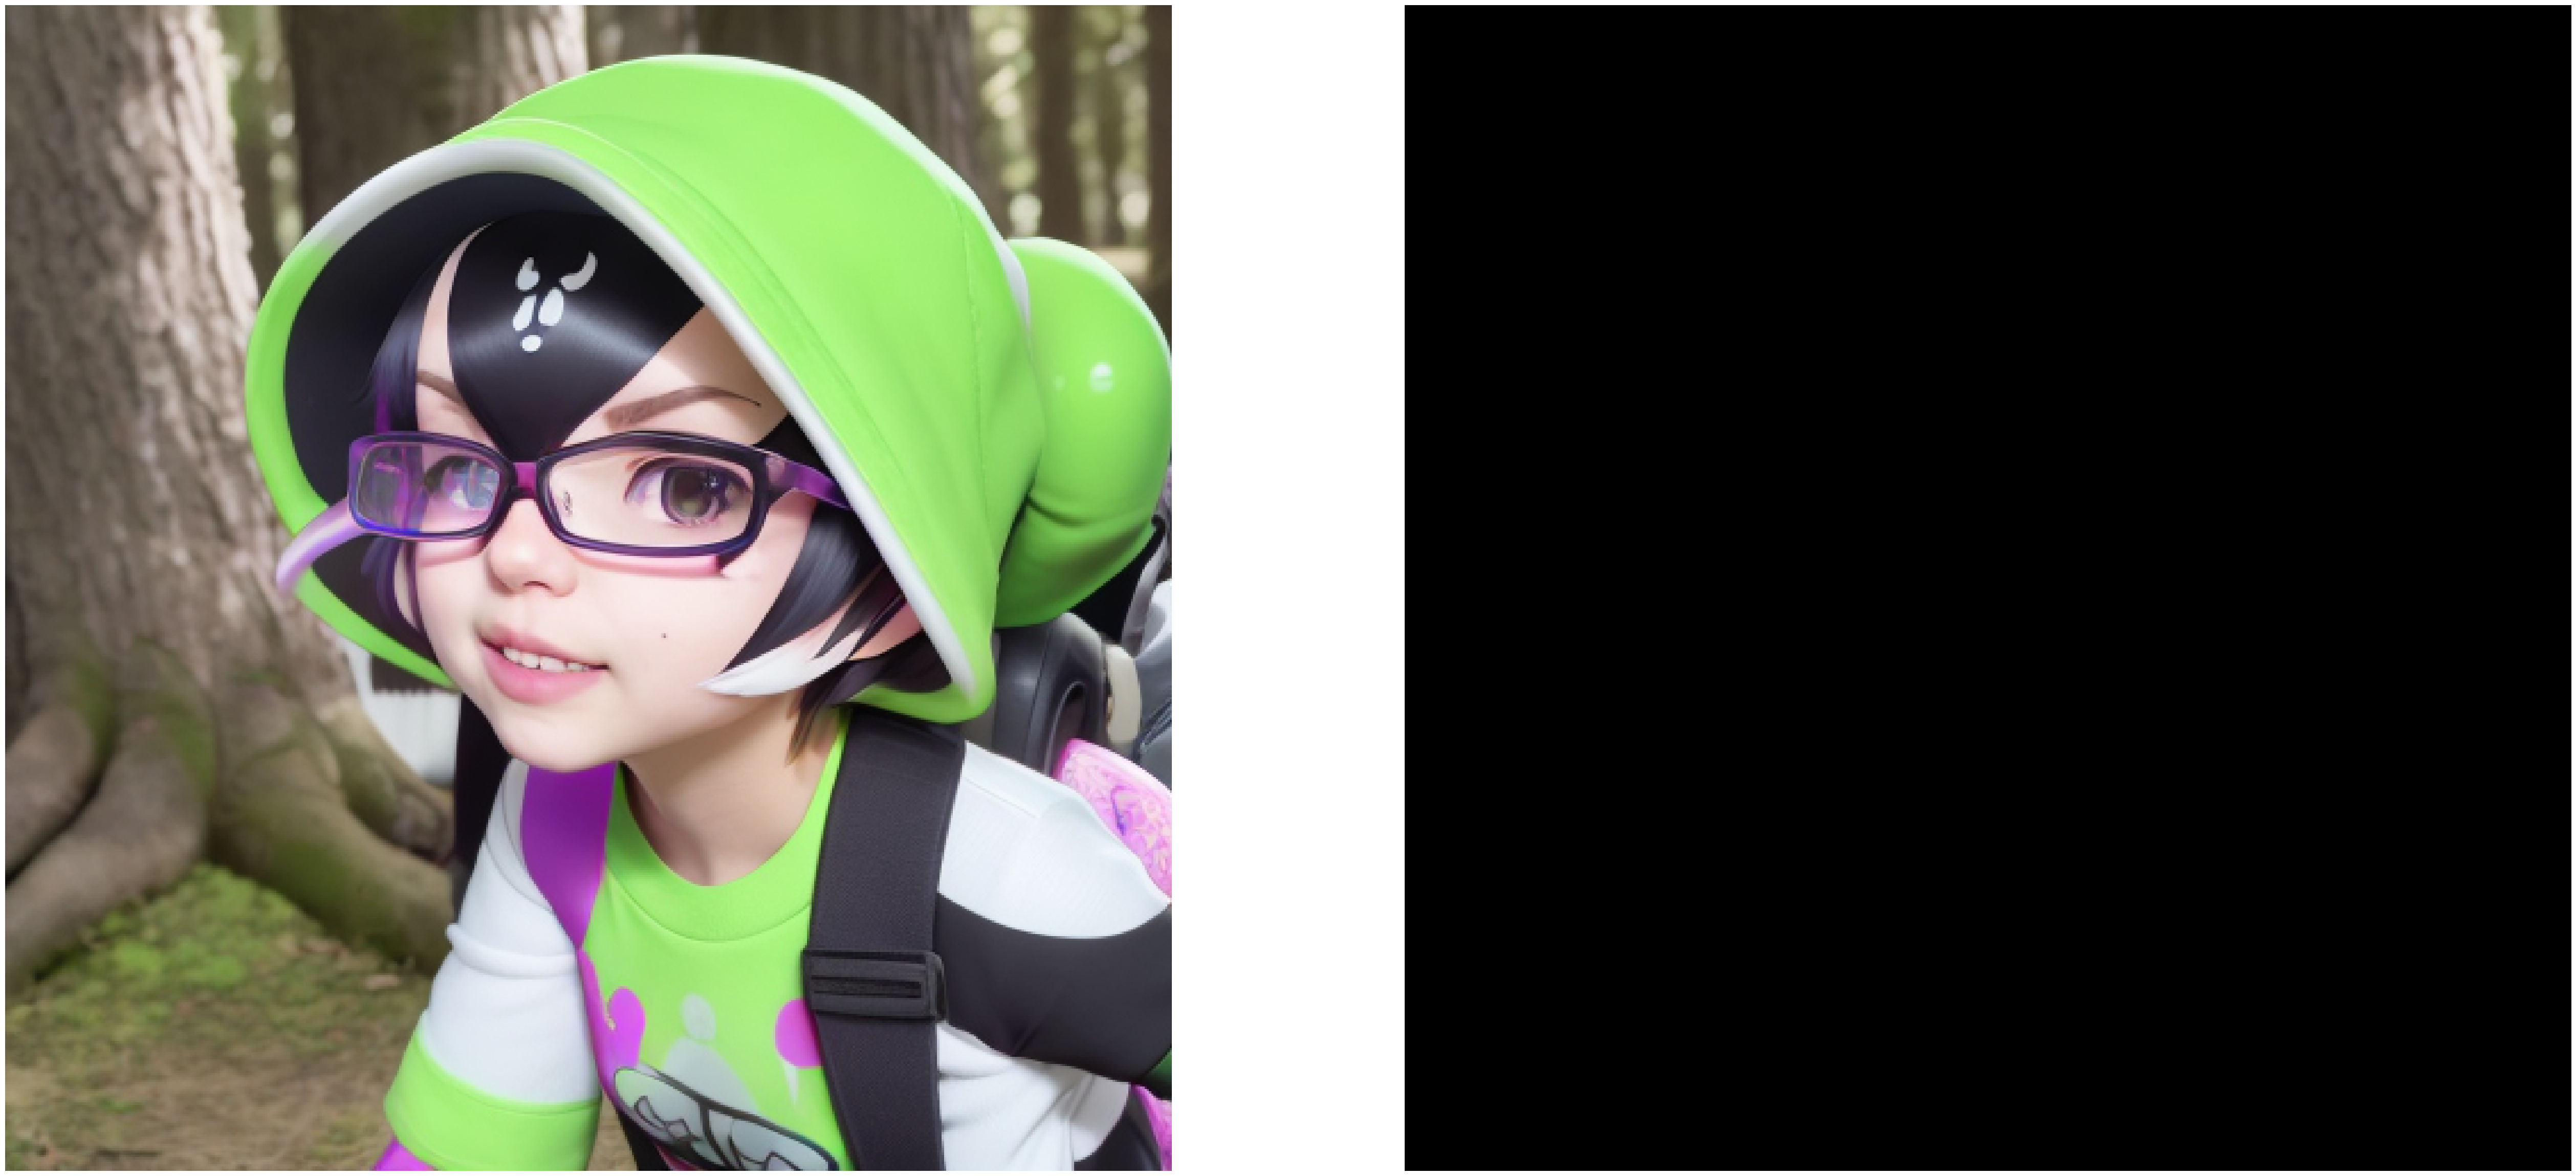

In [51]:
# visualize generation
display_images(ret_images)

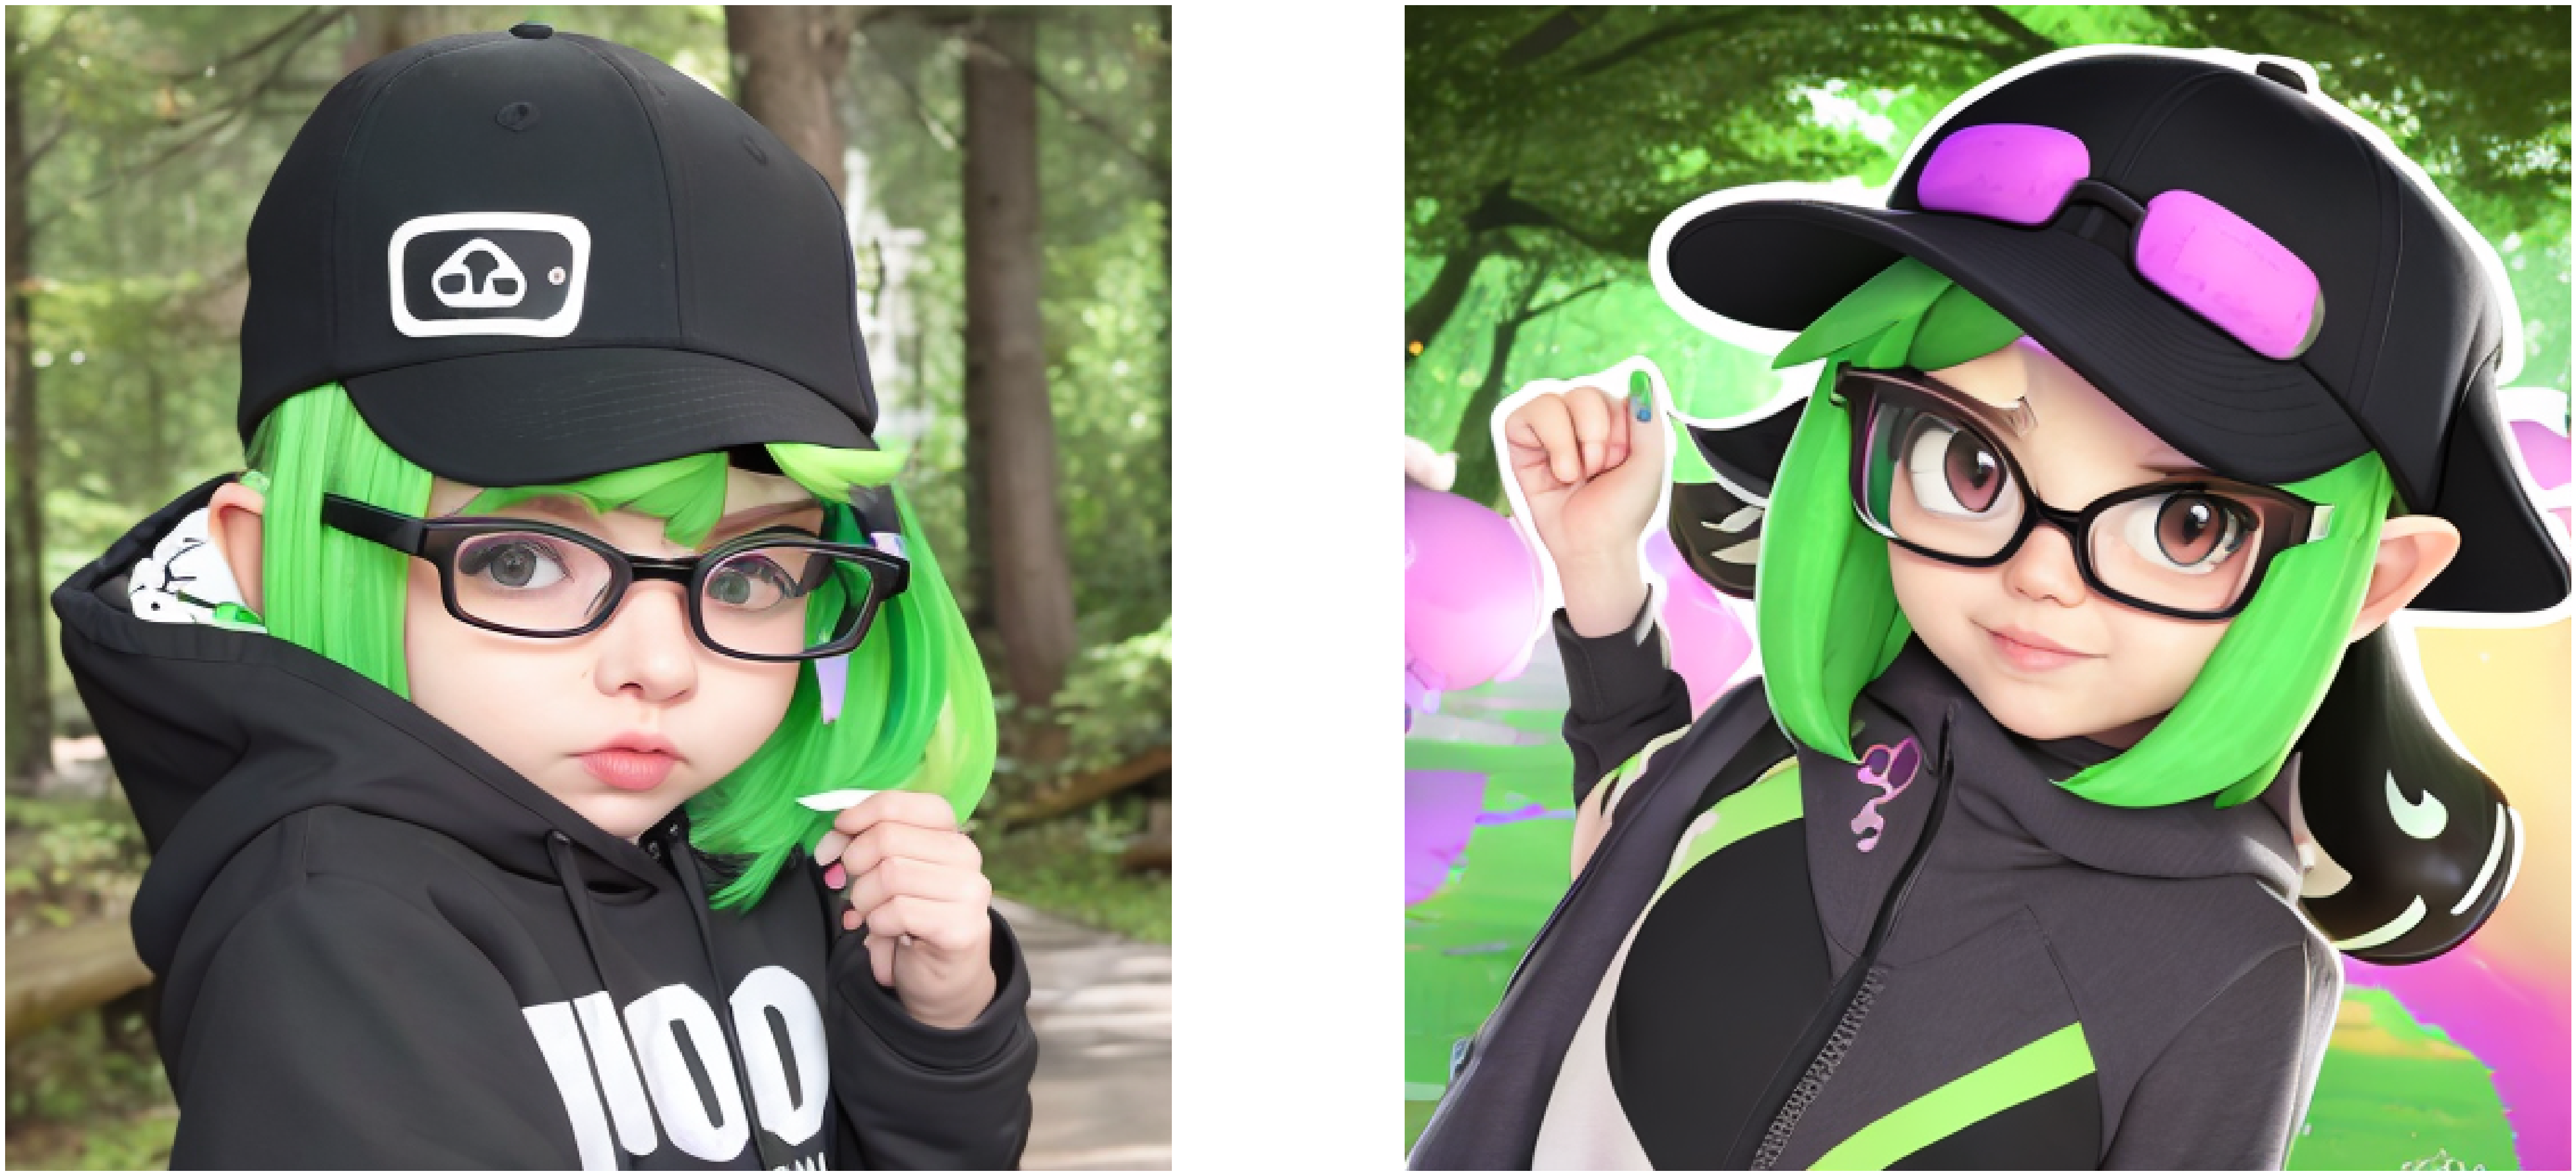

In [22]:
# visualize generation
display_images(ret_images)